In [1]:
import tensorflow as tf
print("Tensorflow version {}".format(tf.__version__))
tf.compat.v1.enable_eager_execution()
import neural_compressor as inc
# try:
#     import neural_compressor as inc
#     print("neural_compressor version {}".format(inc.__version__))  
# except:
#     try:
#         import lpot as inc
#         print("LPOT version {}".format(inc.__version__)) 
#     except:
#         import ilit as inc
#         print("iLiT version {}".format(inc.__version__))       

import matplotlib.pyplot as plt
import numpy as np

from IPython import display

Tensorflow version 2.8.0


In [2]:
%env TF_ENABLE_MKL_NATIVE_FORMAT=0

env: TF_ENABLE_MKL_NATIVE_FORMAT=0


In [3]:
import alexnet
 
data = alexnet.read_data()
x_train, y_train, label_train, x_test, y_test, label_test = data
print('train', x_train.shape, y_train.shape, label_train.shape)
print('test', x_test.shape, y_test.shape, label_test.shape)

Loading data ...
Done
train (60000, 28, 28, 1) (60000, 10) (60000,)
test (10000, 28, 28, 1) (10000, 10) (10000,)


In [4]:
classes = 10
width = 28
channels = 1

model = alexnet.create_model(width ,channels ,classes)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 96)        11712     
                                                                 
 activation (Activation)     (None, 28, 28, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 256)       614656    
                                                                 
 activation_1 (Activation)   (None, 14, 14, 256)       0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 256)        0         
 2D)                                                    

c:\Users\vivek.p\Anaconda\envs\intel_tensorflow\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [5]:
epochs = 1

alexnet.train_mod(model, data, epochs)

100/100 [==============================] - 295s 3s/step - loss: 0.3319 - accuracy: 0.8883 - val_loss: 0.0518 - val_accuracy: 0.9841
Test score: 0.05180659890174866
Test accuracy: 0.9840999841690063


In [7]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def save_frezon_pb(model, mod_path):
    # Convert Keras model to ConcreteFunction
    full_model = tf.function(lambda x: model(x))
    concrete_function = full_model.get_concrete_function(
        x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype))

    # Get frozen ConcreteFunction
    frozen_model = convert_variables_to_constants_v2(concrete_function)

    # Generate frozen pb
    tf.io.write_graph(graph_or_graph_def=frozen_model.graph,
                      logdir=".",
                      name=mod_path,
                      as_text=False)
fp32_frezon_pb_file = "fp32_frezon.pb"
save_frezon_pb(model, fp32_frezon_pb_file)

In [8]:
%ls -la fp32_frezon.pb

 Volume in drive C is OSDisk
 Volume Serial Number is 9C4B-B7DE

 Directory of c:\Project\Workspace\R&D\CGI_Intel _Connect\tensorflow


 Directory of c:\Project\Workspace\R&D\CGI_Intel _Connect\tensorflow

04/14/2023  08:20 PM        27,760,007 fp32_frezon.pb
               1 File(s)     27,760,007 bytes
               0 Dir(s)  736,636,248,064 bytes free


In [9]:
import mnist_dataset
import math


class Dataloader(object):
  def __init__(self, batch_size):
    self.batch_size = batch_size


  def __iter__(self):
    x_train, y_train, label_train, x_test, y_test,label_test = mnist_dataset.read_data()
    batch_nums = math.ceil(len(x_test)/self.batch_size)

    for i in range(batch_nums-1):
        begin = i*self.batch_size
        end = (i+1)*self.batch_size
        yield x_test[begin: end], label_test[begin: end]

    begin = (batch_nums-1)*self.batch_size
    yield x_test[begin:], label_test[begin:]

In [10]:
display.Code('alexnet.py')

import os
import numpy as np

import tensorflow as tf
from tensorflow.python.keras import utils

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Reshape
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow import keras

import mnist_dataset


def save_mod(model, mod_path):
    print("Save to {}".format(mod_path))
    tf.saved_model.save(model, mod_path)


def load_mod(model_file):
    model = tf.keras.models.load_model(model_file)
    print("Load from {}".format(model_file))
    return model


def save_frezon_pb(model, mod_path):
    # Convert Keras model to ConcreteFunction
    full_model = tf.function(lambda x: model(x))
    concrete_function = full_model.get_concrete_function(
        x=tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
    )

    # Get frozen ConcreteFunction
    frozen_model = convert_variables_to_constants_v2(concrete_function)

    # Generate frozen pb
    tf.io.write_graph(
        graph_or_graph_def=frozen_model.graph, logdir=".", name=mod_path, as_text=False
    )


def load_pb(in_model):
    detection_graph = tf.compat.v1.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.compat.v1.GraphDef()
        with tf.compat.v1.gfile.GFile(in_model, "rb") as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.compat.v1.import_graph_def(od_graph_def, name="")

    return detection_graph


def read_data():
    (
        x_train,
        y_train,
        label_train,
        x_test,
        y_test,
        label_test,
    ) = mnist_dataset.read_data()
    return x_train, y_train, label_train, x_test, y_test, label_test


def create_model(w, c, classes):
    model = Sequential()
    model.add(Convolution2D(96, 11, input_shape=(w, w, c), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(256, 5, padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Convolution2D(384, 3, padding="same"))
    model.add(Activation("relu"))

    model.add(Convolution2D(384, 3, padding="same"))
    model.add(Activation("relu"))

    model.add(Convolution2D(256, 3, padding="same"))
    model.add(Activation("relu"))

    model.add(Convolution2D(256, 7))
    model.add(Activation("relu"))

    model.add(Flatten())
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    opt = Adam(lr=0.001)
    model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return model


def train_mod(model, data, epochs=3):
    x_train, y_train, label_train, x_test, y_test, label_test = data
    model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=600,
        validation_data=(x_test, y_test),
        verbose=1,
    )
    score = model.evaluate(x_test, y_test, verbose=0)
    print("Test score:", score[0])
    print("Test accuracy:", score[1])


def main():
    data = read_data()

    classes = 10
    w = 28
    c = 1
    model = create_model(w, c, classes)
    model.summary()

    epochs = 3
    train_mod(model, data, epochs)
    save_mod(model, "alexnet_mnist_fp32_mod")


if __name__ == "__main__":
    main()

In [11]:
display.Code('alexnet.yaml')

version: 1
model:
  name: hello_world
  framework: tensorflow
  inputs: x
  outputs: Identity
evaluation:
  accuracy:
    metric:
      topk: 1
tuning:
  accuracy_criterion:
    relative: 0.01
  exit_policy:
    timeout: 0
  random_seed: 100

In [12]:
def auto_tune(input_graph_path, yaml_config, batch_size):    
    fp32_graph = alexnet.load_pb(input_graph_path)
    quan = inc.Quantization(yaml_config)
    dataloader = Dataloader(batch_size)
    assert(dataloader)
    q_model = quan(
                        fp32_graph,
                        q_dataloader=dataloader,
                        eval_func=None,
                        eval_dataloader=dataloader)
    return q_model


def save_int8_frezon_pb(q_model, path):
    from tensorflow.python.platform import gfile
    f = gfile.GFile(path, 'wb')
    f.write(q_model.as_graph_def().SerializeToString())
    print("Save to {}".format(path))
    
yaml_file = "alexnet.yaml"
batch_size = 200
int8_pb_file = "alexnet_int8_model.pb"

In [13]:
display.Code('inc_quantize_model.py')

import sys

try:
    import neural_compressor as inc

    print("neural_compressor version {}".format(inc.__version__))
except:
    try:
        import lpot as inc

        print("LPOT version {}".format(inc.__version__))
    except:
        import ilit as inc

        print("iLiT version {}".format(inc.__version__))

if inc.__version__ == "1.2":
    print(
        "This script doesn't support LPOT 1.2, please install LPOT 1.1, 1.2.1 or newer"
    )
    sys.exit(1)

import alexnet
import math
import mnist_dataset


def save_int8_frezon_pb(q_model, path):
    from tensorflow.python.platform import gfile

    f = gfile.GFile(path, "wb")
    f.write(q_model.as_graph_def().SerializeToString())
    print("Save to {}".format(path))


class Dataloader(object):
    def __init__(self, batch_size):
        self.batch_size = batch_size

    def __iter__(self):
        (
            x_train,
            y_train,
            label_train,
            x_test,
            y_test,
            label_test,
        ) = mnist_dataset.read_data()
        batch_nums = math.ceil(len(x_test) / self.batch_size)

        for i in range(batch_nums - 1):
            begin = i * self.batch_size
            end = (i + 1) * self.batch_size
            yield x_test[begin:end], label_test[begin:end]

        begin = (batch_nums - 1) * self.batch_size
        yield x_test[begin:], label_test[begin:]


def auto_tune(input_graph_path, yaml_config, batch_size):
    fp32_graph = alexnet.load_pb(input_graph_path)
    quan = inc.Quantization(yaml_config)
    dataloader = Dataloader(batch_size)

    q_model = quan(
        fp32_graph, q_dataloader=dataloader, eval_func=None, eval_dataloader=dataloader
    )
    return q_model


yaml_file = "alexnet.yaml"
batch_size = 200
fp32_frezon_pb_file = "fp32_frezon.pb"
int8_pb_file = "alexnet_int8_model.pb"

q_model = auto_tune(fp32_frezon_pb_file, yaml_file, batch_size)
save_int8_frezon_pb(q_model, int8_pb_file)

In [14]:
!python inc_quantize_model.py

neural_compressor version 1.14.2

2023-04-14 20:21:08 [WARNING] This API is going to be deprecated. Please import neural_compressor.experimental.Quantization, initialize an instance of `Quantization`,set its dataloader and metric attributes, then invoke its __call__ method.
2023-04-14 20:21:08 [WARNING] Force convert framework model to neural_compressor model.
2023-04-14 20:21:08.492452: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 20:21:08 [INFO] ConvertLayoutOptimizer elapsed time: 0.0 ms
2023-04-14 20:21:08.789756: I tensorflow/core/grappler/devices.cc:75] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
2023-04-14 20:21:08.790112: I tensorflow/core/grappler


Loading data ...
Done
Loading data ...
Done
Loading data ...
Done
Save to alexnet_int8_model.pb


In [15]:
display.Code('profiling_inc.py')

import tensorflow as tf

print("Tensorflow version {}".format(tf.__version__))

import numpy as np
import time
import argparse
import os
import json


import mnist_dataset
import alexnet


def val_data():
    (
        x_train,
        y_train,
        label_train,
        x_test,
        y_test,
        label_test,
    ) = mnist_dataset.read_data()
    return x_test, y_test, label_test


def calc_accuracy(predictions, labels):
    predictions = np.argmax(predictions, axis=1)
    same = 0
    for i, x in enumerate(predictions):
        if x == labels[i]:
            same += 1
    if len(predictions) == 0:
        return 0
    else:
        return same / len(predictions)


def get_concrete_function(graph_def, inputs, outputs, print_graph=False):
    def imports_graph_def():
        tf.compat.v1.import_graph_def(graph_def, name="")

    wrap_function = tf.compat.v1.wrap_function(imports_graph_def, [])
    graph = wrap_function.graph

    return wrap_function.prune(
        tf.nest.map_structure(graph.as_graph_element, inputs),
        tf.nest.map_structure(graph.as_graph_element, outputs),
    )


def infer_perf_pb(pb_model_file, val_data, inputs=["x:0"], outputs=["Identity:0"]):
    x_test, y_test, label_test = val_data
    q_model = alexnet.load_pb(pb_model_file)
    concrete_function = get_concrete_function(
        graph_def=q_model.as_graph_def(),
        inputs=inputs,
        outputs=outputs,
        print_graph=True,
    )

    bt = time.time()
    _frozen_graph_predictions = concrete_function(x=tf.constant(x_test))
    et = time.time()

    accuracy = calc_accuracy(_frozen_graph_predictions[0], label_test)
    print("accuracy:", accuracy)
    throughput = x_test.shape[0] / (et - bt)
    print("max throughput(fps):", throughput)

    # latency when BS=1
    times = 1000
    single_test = x_test[:1]

    bt = 0
    warmup = 20
    for i in range(times):
        if i == warmup:
            bt = time.time()
        _frozen_graph_predictions = concrete_function(x=tf.constant(single_test))
    et = time.time()

    latency = (et - bt) * 1000 / (times - warmup)
    print("latency(ms):", latency)

    return accuracy, throughput, latency


def save_res(result):
    accuracy, throughput, latency = result
    res = {}
    res["accuracy"] = accuracy
    res["throughput"] = throughput
    res["latency"] = latency

    outfile = args.index + ".json"
    with open(outfile, "w") as f:
        json.dump(res, f)
        print("Save result to {}".format(outfile))


parser = argparse.ArgumentParser()
parser.add_argument("--index", type=str, help="file name of output", required=True)

parser.add_argument(
    "--input-graph", type=str, help="file name for graph", required=True
)

parser.add_argument(
    "--num-intra-threads",
    type=str,
    help="number of threads for an operator",
    required=False,
    default="24",
)
parser.add_argument(
    "--num-inter-threads",
    type=str,
    help="number of threads across operators",
    required=False,
    default="1",
)
parser.add_argument(
    "--omp-num-threads",
    type=str,
    help="number of threads to use",
    required=False,
    default="24",
)

args = parser.parse_args()
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "0"
os.environ["OMP_NUM_THREADS"] = args.omp_num_threads
os.environ["TF_NUM_INTEROP_THREADS"] = args.num_inter_threads
os.environ["TF_NUM_INTRAOP_THREADS"] = args.num_intra_threads

save_res(infer_perf_pb(args.input_graph, val_data()))

In [16]:
!python profiling_inc.py --input-graph=./fp32_frezon.pb --omp-num-threads=4 --num-inter-threads=1 --num-intra-threads=4 --index=32

Tensorflow version 2.8.0
Loading data ...
Done
accuracy: 0.9841
max throughput(fps): 519.7890245740645
latency(ms): 3.249741573722995
Save result to 32.json


2023-04-14 20:22:00.324231: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [17]:
!python profiling_inc.py --input-graph=./alexnet_int8_model.pb --omp-num-threads=4 --num-inter-threads=1 --num-intra-threads=4 --index=8

2023-04-14 20:22:28.676691: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX AVX2

Tensorflow version 2.8.0
Loading data ...
Done
accuracy: 0.9824
max throughput(fps): 1497.1850392295446
latency(ms): 1.4934041062179877
Save result to 8.json



To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
display.Code('32.json')
!echo " "
display.Code('8.json')

" "


{"accuracy": 0.9824, "throughput": 1497.1850392295446, "latency": 1.4934041062179877}

throughputs [519.7890245740645, 1497.1850392295446]
latencys [3.249741573722995, 1.4934041062179877]
accuracys [0.9841, 0.9824]


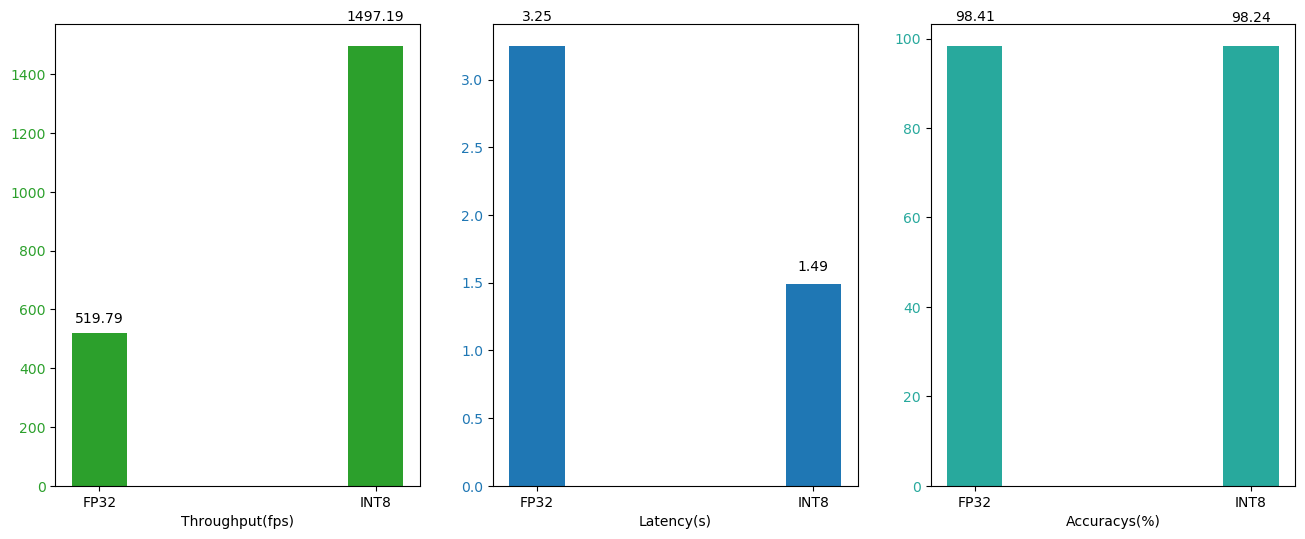

In [19]:
import json

def autolabel(ax, rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%0.2f' % float(height),
        ha='center', va='bottom')

def draw_bar(x, t, y, subplot, color, x_lab, y_lab, width=0.2):
    plt.subplot(subplot)
    plt.xticks(x, t)
    ax1 = plt.gca()
    ax1.set_xlabel(x_lab)
    ax1.set_ylabel(y_lab, color=color)
    rects1 = ax1.bar(x, y, color=color, width=width)
    ax1.tick_params(axis='y', labelcolor=color)
    autolabel(ax1, rects1)

def load_res(json_file):
    with open(json_file) as f:
        data = json.load(f)
        return data

res_32 = load_res('32.json')
res_8 = load_res('8.json')
   
accuracys = [res_32['accuracy'], res_8['accuracy']]
throughputs = [res_32['throughput'], res_8['throughput']]             
latencys = [res_32['latency'], res_8['latency']]

print('throughputs', throughputs)
print('latencys', latencys)
print('accuracys', accuracys)

accuracys_perc = [accu*100 for accu in accuracys]

t = ['FP32', 'INT8']
x = [0, 1]
plt.figure(figsize=(16,6))
draw_bar(x, t, throughputs, 131, 'tab:green', 'Throughput(fps)', '', width=0.2)
draw_bar(x, t,  latencys, 132, 'tab:blue', 'Latency(s)', '', width=0.2)
draw_bar(x, t,  accuracys_perc, 133, '#28a99d', 'Accuracys(%)', '', width=0.2)
plt.show()

throughputs_times [1, 2.880370628172453]
latencys_times [1, 0.45954549687688]
accuracys_times [0, -0.1699999999999875]


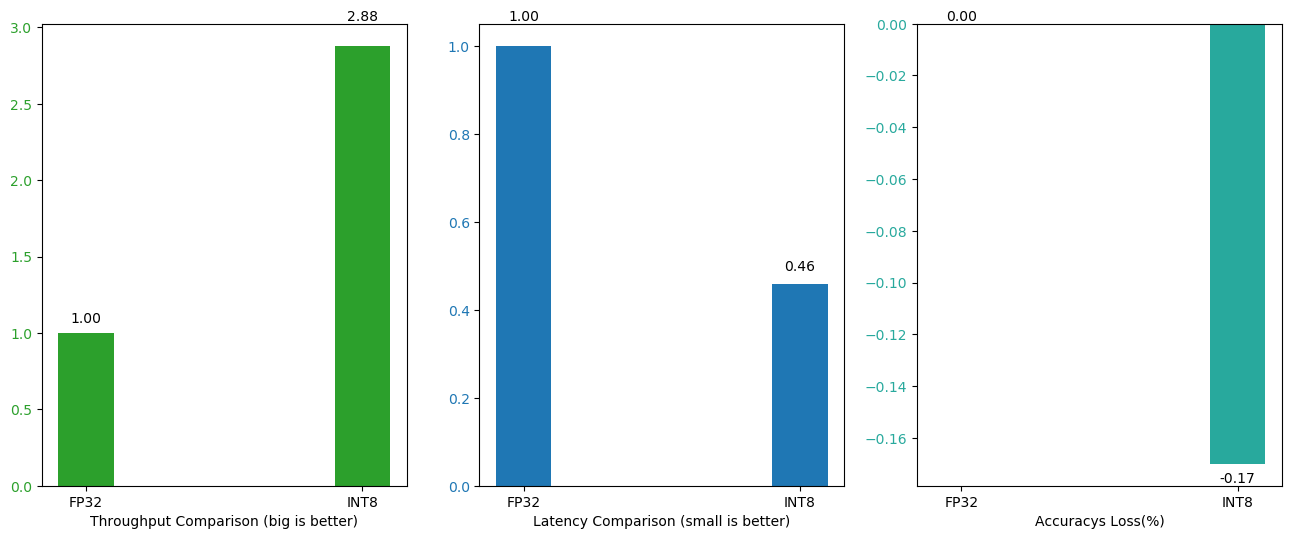

In [20]:
throughputs_times = [1, throughputs[1]/throughputs[0]]
latencys_times = [1, latencys[1]/latencys[0]]
accuracys_times = [0, accuracys_perc[1] - accuracys_perc[0]]

print('throughputs_times', throughputs_times)
print('latencys_times', latencys_times)
print('accuracys_times', accuracys_times)

plt.figure(figsize=(16,6))
draw_bar(x, t, throughputs_times, 131, 'tab:green', 'Throughput Comparison (big is better)', '', width=0.2)
draw_bar(x, t, latencys_times, 132, 'tab:blue', 'Latency Comparison (small is better)', '', width=0.2)
draw_bar(x, t, accuracys_times, 133, '#28a99d', 'Accuracys Loss(%)', '', width=0.2)
plt.show()